# <center>Site-level Study on Pollution Outcomes with Policy Effects:</center>
## <center>Data Pipeline</center>

## Overview of Datasets

| Dataset | Temporal Resolution | Role | Notes / Links |
|---|---|---|---|
| **EEA Industrial Emissions Portal - LCP** | Annual (wide) | **EU** large-combustion plant attributes & coordinates | EU plant universe. Provides yearly `capacity_mw` and `fuel_shares`. [EEA LCP](https://industry.eea.europa.eu/explore/explore-lcp) |
| **EU Registry on Industrial Sites** | Annual | LCP <-> ETS installation linkage | Official crosswalk from EEA. Downloaded from [EEA SDI Catalogue](https://sdi.eea.europa.eu/catalogue/srv/eng/catalog.search#/meta21e758c6-a9ac-4a7d-a64a-19d2ba9eecb7). Extracted `ETSIdentifiers.csv` and `ProductionInstallationPart.csv` from AccessDB file using [mdbtools](https://github.com/brianb/mdbtools). |
| **EU ETS (pyeutl)** | First compliance year -> **yearly** | Installation-level emissions & allowances | Loaded from **EUETS.INFO extracts** via [`pyeutl`](https://github.com/jabrell/pyeutl). Data from [EUETS.INFO](https://euets.info/). |
| **NUTS Regions** | Static | Spatial clustering | Eurostat NUTS2 regions for clustered SEs and Region x Year FE. [Eurostat GISCO](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). Download: `NUTS_RG_10M_2021_4326_LEVL_2.geojson` |
| **PyPSA-Eur Clusters** | Static | Electricity heterogeneity | k-means clusters on transmission network topology. [PyPSA-Eur](https://pypsa-eur.readthedocs.io/). Generated via Snakemake workflow. |
| **TROPOMI NO2 (S5P)** | Daily -> yearly | Outcome variable | Tropospheric NO2 column density processed via **Beirle-style flux divergence method**. [GEE Dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2). Reference: [Beirle et al. (2023)](https://doi.org/10.5194/essd-15-3051-2023). |
| **ERA5-Land Hourly** | Daily -> yearly | Wind fields | Daily wind u/v components for advection computation; calm days (< 2 m/s) excluded. [GEE Dataset](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY). |
| **GHSL SMOD** | Static | Urbanization degree | JRC Degree of Urbanisation raster (1 km). Used for heterogeneity analysis. [GEE Dataset](https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_SMOD_V2-0). |
| **AlphaEarth Embeddings** | Annual | Geographic context | Google Satellite Embedding V1 for land use, infrastructure, climate controls. [GEE Dataset](https://developers.google.com/earth-engine/datasets/catalog/google_research_open_buildings_temporal_embeddings_v1_0). |

---

## Data Model

### Key Entities
- **Facility** = Physical combustion plant(s) grouped by 500m spatial proximity (`idx` = primary key)
- **EU ETS Installation** = Regulatory compliance unit (many-to-one relationship with LCP)

### Time-Varying vs Static Attributes
| Attribute Type | Examples | Panel Structure |
|---|---|---|
| **Static** | Coordinates, country, plant names, ETS / LCP identifiers, urbanization, **NUTS2 region**, **PyPSA cluster**, **interference flag** | One row per facility |
| **Time-Varying** | Capacity (MW), fuel shares, ETS emissions, satellite NOx emissions, embeddings | Plant x year panel |

### Clustering Strategy
- **NUTS2 Regions** (Primary): Eurostat administrative regions used for clustered standard errors and Region x Year fixed effects
- **PyPSA-Eur Regions** (Hetereogeneity): Power system clusters for electricity sector analysis

---

## Outputs

This notebook produces **three main output files**:

#### 1. `out/facilities_static.parquet` - Static Attributes
One row per facility with time-invariant characteristics:

| Column | Description |
|---|---|
| `idx` | Facility identifier (primary key) |
| `lat`, `lon` | Coordinates (centroid of clustered plants) |
| `country_code` | ISO-2 country code |
| `name` | Plant name(s) |
| `LCPInspireId` | LCP INSPIRE identifier(s) |
| `ets_id` | EU ETS installation identifier(s) |
| `is_electricity` | Boolean: True if EU ETS activity code is combustion (1 or 20) - for electricity sector heterogeneity |
| `nuts2_region` | NUTS2 region code - **primary clustering for SEs and FE** |
| `pypsa_cluster` | PyPSA-Eur cluster ID - for electricity sector heterogeneity |
| `urbanization_degree` | GHSL SMOD code (10-30) - for heterogeneity analysis |
| `in_urban_area` | Boolean: SMOD >= 21 (suburban+) - for heterogeneity analysis |
| `interfered_20km` | Boolean: another ETS facility within 20 km (satellite cluster-level outcome) |

#### 2. `out/facilities_yearly.parquet` - Time-Varying Panel
Plant x year panel with all time-varying covariates:

| Column Group | Columns | Source |
|---|---|---|
| **Keys** | `idx`, `year` | - |
| **Capacity** | `capacity_mw` | LCP (yearly) |
| **Fuel Mix** | `share_gas`, `share_coal`, `share_oil`, `share_biomass`, ... | LCP (yearly) |
| **ETS Exposure** | `eu_verified_tco2`, `eu_alloc_total_tco2`, `eu_shortfall_tco2`, `eu_alloc_ratio`, `n_installations` | EU ETS |

#### 3. `out/beirle_panel.parquet` - Satellite NOx Emission Estimates
Facility x year panel with Beirle-style NOx emission estimates. **Note**: We skip Beirle's automatic point-source identification (we have known ETS/LCP locations) but follow their quantification and significance logic via boolean flags.

| Column | Description |
|---|---|
| `idx`, `year` | Keys |
| `beirle_nox_kg_s` | NOx emission rate [kg/s] |
| `beirle_nox_kg_s_se` | Statistical standard error [kg/s] |
| `rel_err_stat` | Relative statistical integration error |
| `rel_err_total` | Combined relative uncertainty (~35-45%) |
| `n_days_satellite` | Number of valid satellite days |
| `emb_{band}` | 64-dim Geospatial AlphaEarth Embedding | 
| **Significance Flags** | |
| `above_dl_0_11` | Emission >= 0.11 kg/s (standard European detection limit) |
| `above_dl_0_03` | Emission >= 0.03 kg/s (permissive, high-albedo desert only) |
| `rel_err_stat_lt_0_3` | Statistical error < 30% |

In [6]:
import pandas as pd 
from pandas import DataFrame
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree # type: ignore

BEIRLE_EXPORT_DIR = "ee_beirle_exports"
EMBEDDING_EXPORT_DIR = "ee_embedding_exports"
LCP_ETS_DIR = "LCP_ETS_DATA"
LCP_PATH = f"{LCP_ETS_DIR}/EEA_Industry_Dataset_LCP.xlsx"
INSTALL_PART_PATH = f"{LCP_ETS_DIR}/ProductionInstallationPart.csv"
ETS_ID_PATH       = f"{LCP_ETS_DIR}/ETSIdentifiers.csv"
EUETS_ZIP = "eutl_2024_202410/eutl_2024_202410.zip"
NUTS_GEOJSON_PATH = "nuts/NUTS_RG_10M_2021_4326_LEVL_2.geojson"
PYPSA_CLUSTERS_PATH = "pypsa_clusters/regions_onshore_elec_s128.geojson"
FAC_ID_COL = 'idx'

START_YEAR = 2018
END_YEAR = 2023
MIN_YEARS = 3 # Minimum number of years to per facility
MIN_WIND_SPEED_MS = 2.0    # Minimum wind speed threshold (Beirle Sect. 3.5)
MIN_DAYS_PER_YEAR = 20     # Minimum valid observation days per facility-year
PYPSA_RESOLUTION = "128"


os.makedirs("out", exist_ok=True)

## 1. LCP Facilities
### Load, Clean and Aggregate EEA Large Combustion Plants (LCP) data to get facilities + yearly attributes panel
#### Filters
- **Year**: We filter to the years 2018-2023.
- **Fuels**: We filter out fuels used by less than 10% of facilities and remove facitlities with no
  other fuels.

### Helpers

In [7]:
from facilities import fuel_group_map

### Ingest LCP Data

In [8]:
plants = pd.read_excel(LCP_PATH, sheet_name="LCP_Energy_Emissions", dtype={"LCPInspireId": str})

year_cols = [
    c for c in plants.columns
    if re.fullmatch(r"\d{4}", str(c)) and int(START_YEAR) <= int(c) <= int(END_YEAR)
]

# ISO-2 from 'AT.CAED/...' prefix
plants["country_code"] = plants["LCPInspireId"].str.split(".").str[0].str.upper()

# Drop rows where country_code starts with "HTTP"
plants = plants[~plants["country_code"].str.startswith("HTTP", na=False)] 

print(f"Loaded {plants['LCPInspireId'].nunique():,} unique LCP plants from {LCP_PATH}") # type: ignore

Loaded 3,405 unique LCP plants from LCP_ETS_DATA/EEA_Industry_Dataset_LCP.xlsx


### Gather Plant Level Time-Varying Data

#### Yearly Capacity

In [9]:
cap_rows = plants[
    (plants["featureType"] == "LCPCharacteristics") &
    (plants["unit"].astype(str).str.upper() == "MW") # type: ignore
].copy()

# Melt year columns to long format for yearly capacity
cap_long = cap_rows.melt( # type: ignore
    id_vars=["LCPInspireId"],
    value_vars=year_cols,
    var_name="year",
    value_name="capacity_mw"
)
cap_long["year"] = cap_long["year"].astype(int)
cap_long["capacity_mw"] = pd.to_numeric(cap_long["capacity_mw"], errors="coerce").fillna(0) # type: ignore

# Aggregate capacity by plant × year (sum if multiple rows per plant)
capacity_yearly = (
    cap_long.groupby(["LCPInspireId", "year"], as_index=False)
    .agg(capacity_mw=("capacity_mw", "sum"))
)

# Drop plant-years with capacity = 0
capacity_yearly = capacity_yearly[capacity_yearly["capacity_mw"] > 0]

print(f"Built yearly capacity panel: {len(capacity_yearly):,} rows, "
      f"{capacity_yearly['LCPInspireId'].nunique():,} plants") # type: ignore

Built yearly capacity panel: 14,653 rows, 2,983 plants


In [10]:
capacity_yearly.sample(5) # type: ignore

,LCPInspireId,year,capacity_mw
14120,PL.MŚ/000000093.PART,2020,56.7
14756,PL.MŚ/000000211.PART,2020,135.0
18254,SE.CAED/10039522.Part,2020,400.0
3434,EL.CAED/100066.PART,2020,109.2
4374,ES.CAED/001986007.PART,2018,88.0


#### Yearly Fuel Energy Usage

In [11]:
# Build yearly fuel-energy panel (plant × year × fuel_group) in TJ
# Keep raw TJ values - shares will be computed after facility-level aggregation
FUEL_FEATURES = [
    "Coal","Lignite","OtherSolidFuels","NaturalGas","LiquidFuels",
    "OtherGases","Peat","Biomass"
]
fuel_rows = plants[
    plants["featureType"].isin(FUEL_FEATURES) &  # type: ignore
    (plants["unit"].astype(str).str.upper() == "TJ")  # type: ignore
].copy()

fuel_energy_yearly = DataFrame()  # plant × year panel with fuel energy (TJ)

fuel_rows["fuel_group"] = fuel_rows["featureType"].apply(fuel_group_map) # type: ignore

# Melt year columns to long format: one row per (plant, fuel_group, year)
fuel_long = fuel_rows.melt( # type: ignore
    id_vars=["LCPInspireId", "fuel_group"],
    value_vars=year_cols,
    var_name="year",
    value_name="energy_tj"
) # type: ignore
fuel_long["year"] = fuel_long["year"].astype(int)
fuel_long["energy_tj"] = pd.to_numeric(fuel_long["energy_tj"], errors="coerce").fillna(0) # type: ignore

# Sum energy by plant × year × fuel_group (in case multiple rows per combination)
fuel_agg = (
    fuel_long.groupby(["LCPInspireId", "year", "fuel_group"], as_index=False)
    .agg(energy_tj=("energy_tj", "sum"))
)

# Pivot to wide format: one column per fuel_group (TJ values, not shares)
fuel_energy_yearly = fuel_agg.pivot_table(
    index=["LCPInspireId", "year"],
    columns="fuel_group",
    values="energy_tj",
    fill_value=0
).reset_index()

# Prefix columns for clarity (energy in TJ)
fuel_cols = [c for c in fuel_energy_yearly.columns if c not in ["LCPInspireId", "year"]]
fuel_energy_yearly = fuel_energy_yearly.rename(
    columns={c: f"energy_tj_{c.lower().replace(' ', '_').replace('/', '_')}" for c in fuel_cols}
)

# Drop rows where all fuel energy values are 0
energy_cols = [c for c in fuel_energy_yearly.columns if c.startswith("energy_tj_")]
fuel_energy_yearly = fuel_energy_yearly[fuel_energy_yearly[energy_cols].sum(axis=1) > 0]

print(f"Built yearly fuel energy panel: {len(fuel_energy_yearly):,} rows, "
        f"{fuel_energy_yearly['LCPInspireId'].nunique():,} plants, " # type: ignore
        f"{fuel_energy_yearly['year'].nunique()} years") # type: ignore

Built yearly fuel energy panel: 13,413 rows, 2,826 plants, 6 years


In [12]:
fuel_energy_yearly.sample(5)

fuel_group,LCPInspireId,year,energy_tj_biomass,energy_tj_coal,energy_tj_gas,energy_tj_oil,energy_tj_other_gas,energy_tj_other_solid,energy_tj_peat
17782,SE.CAED/10000075.Part,2022,0.00000,0.0,0.000000,9.79,0.0,0.0,0.0
12597,NL.RIVM/044008001.PART,2021,0.00000,0.0,760.943163,0.00,0.0,0.0,0.0
10291,IT.CAED/670512001.PART,2019,0.00000,0.0,2475.996846,0.00,0.0,0.0,0.0
6374,FR.CAED/30500.A.INSTALLATIONPART,2020,2807.02002,0.0,0.000000,0.00,0.0,0.0,0.0
4593,ES.CAED/003518000.PART,2021,0.00000,0.0,11560.000000,0.00,0.0,0.0,0.0


#### Merge and Filter

In [13]:
# Merge capacity and fuel energy into single LCP yearly panel
plants_yearly = capacity_yearly.merge(fuel_energy_yearly, on=["LCPInspireId", "year"], how="inner") # type: ignore

# Filter Years
plants_yearly = plants_yearly[plants_yearly["year"] >= START_YEAR]
plants_yearly = plants_yearly[plants_yearly["year"] <= END_YEAR]

print(f"Combined LCP yearly panel for {START_YEAR} to {END_YEAR}: {len(plants_yearly):,} rows")

Combined LCP yearly panel for 2018 to 2023: 13,386 rows


In [14]:
plants_yearly.sample(5) # type: ignore

,LCPInspireId,year,capacity_mw,energy_tj_biomass,energy_tj_coal,energy_tj_gas,energy_tj_oil,energy_tj_other_gas,energy_tj_other_solid,energy_tj_peat
4755,FR.CAED/7783.A.INSTALLATIONPART,2020,420.00,0.000000,0.0,4663.310059,0.0,0.0,0.0,0.0
6630,IT.CAED/330282002.PART,2021,140.88,0.000000,0.0,2337.509380,0.0,0.0,0.0,0.0
4447,FR.CAED/5388.A.INSTALLATIONPART,2021,99.00,272.065857,0.0,262.605255,0.0,0.0,0.0,0.0
6264,IT.CAED/200992009.PART,2019,56.00,0.000000,0.0,229.532136,0.0,0.0,0.0,0.0
10032,PL.MŚ/000000138.PART,2020,110.00,0.000000,1653.6,232.100000,0.0,0.0,0.0,0.0


### Build static plant attributes 

In [15]:
# Build static plant attributes with ETS linking
plants_static = (
    cap_rows.assign( # type: ignore
        capacity_mw_min=cap_rows[year_cols].replace(0, np.nan).min(axis=1, skipna=True)  # type: ignore 
    )
    .groupby("LCPInspireId", as_index=False)
    .agg(
        name=("installationPartName", "first"),
        lon=("Longitude", "first"),
        lat=("Latitude", "first"),
        country_code=("country_code", "first"),
    )
)

# Filter to plants that have complete data in plants_yearly (after inner join)
valid_lcp_ids = set(plants_yearly["LCPInspireId"].unique()) # type: ignore
n_before = len(plants_static)
plants_static = plants_static[plants_static["LCPInspireId"].isin(valid_lcp_ids)] # type: ignore
print(f"Filtered to {len(plants_static):,} plants with complete LCP data (dropped {n_before - len(plants_static):,})")

# Link LCP parts to ETS installation IDs Using EU Registry on Industrial Sites

# ProductionInstallationPart.csv: LCP part -> parent installation
ipp = pd.read_csv(
    INSTALL_PART_PATH,
    dtype={
        "Installation_Part_INSPIRE_ID": str,
        "Parent_Installation_INSPIRE_ID": str
    }
)

lcp_install = (
    ipp[["Installation_Part_INSPIRE_ID", "Parent_Installation_INSPIRE_ID"]]
    .drop_duplicates()
    .rename(columns={"Installation_Part_INSPIRE_ID": "LCPInspireId"}) # type: ignore
) 

# ETSIdentifiers.csv: installation -> ETSIdentifier (+ reporting year)
ets = pd.read_csv(ETS_ID_PATH, dtype={"Installation_INSPIRE_ID": str})

# If ReportingYear exists, restrict to desired window and keep latest in window
if "ReportingYear" in ets.columns:
    ets["ReportingYear"] = pd.to_numeric(ets["ReportingYear"], errors="coerce")
    ets = ets[
        (ets["ReportingYear"] >= int(START_YEAR)) &
        (ets["ReportingYear"] <= int(END_YEAR))
    ]
    ets = (
        ets.sort_values(["Installation_INSPIRE_ID", "ReportingYear"]) # type: ignore
           .drop_duplicates("Installation_INSPIRE_ID", keep="last")
    )

# Merge LCP -> installation
plants_static = plants_static.merge( # type: ignore
    lcp_install,
    on="LCPInspireId",
    how="left"
)

# Merge installation -> ETSIdentifier
plants_static = plants_static.merge(
    ets[["Installation_INSPIRE_ID", "ETSIdentifier"]],
    left_on="Parent_Installation_INSPIRE_ID",
    right_on="Installation_INSPIRE_ID",
    how="left"
)

plants_static = plants_static.drop(columns=["Parent_Installation_INSPIRE_ID", "Installation_INSPIRE_ID"], errors="ignore")

# Aggregate ETS IDs into list per LCPInspireId (1 LCP can have multiple ETS installations)
n_before_agg = len(plants_static)
plants_static = (
    plants_static.groupby("LCPInspireId", as_index=False)
    .agg({
        "name": "first",
        "lon": "first",
        "lat": "first",
        "country_code": "first",
        "ETSIdentifier": lambda x: list(x.dropna().unique())  # collect all ETS IDs
    })
    .rename(columns={"ETSIdentifier": "ets_id"}) 
) # type: ignore

n_with_ets = (plants_static["ets_id"].apply(len) > 0).sum()
print(f"Aggregated ETS IDs: {n_before_agg:,} → {len(plants_static):,} rows | {n_with_ets:,} plants have ≥1 ETS ID")

# Drop plants without any ETS IDs from both plants_static and plants_yearly
n_before_ets = len(plants_static)
plants_static = plants_static[plants_static["ets_id"].apply(len) > 0]
plants_with_ets = set(plants_static["LCPInspireId"].unique()) # type: ignore

plants_yearly = plants_yearly[plants_yearly["LCPInspireId"].isin(plants_with_ets)] # type: ignore

print(f"Dropped {n_before_ets - len(plants_static):,} plants without ETS IDs")
print(f"Final: plants_static has {len(plants_static):,} plants | plants_yearly has {len(plants_yearly):,} rows ({plants_yearly['LCPInspireId'].nunique():,} plants for years {plants_yearly['year'].min()}-{plants_yearly['year'].max()})") # type: ignore

# Drop Plants from plants_static that are not in plants_yearly
plants_static = plants_static[plants_static["LCPInspireId"].isin(plants_yearly["LCPInspireId"])] # type: ignore

# Sanity check
assert len(plants_static) == plants_yearly["LCPInspireId"].nunique(), "Mismatch between plants_static and plants_yearly!" # type: ignore

Filtered to 2,821 plants with complete LCP data (dropped 584)
Aggregated ETS IDs: 9,175 → 2,821 rows | 1,580 plants have ≥1 ETS ID
Dropped 1,241 plants without ETS IDs
Final: plants_static has 1,580 plants | plants_yearly has 7,413 rows (1,580 plants for years 2018-2023)


### Aggregate plants to Facility level

In [16]:
# Filter plants_static to valid coordinates
fac_base = plants_static.dropna(subset=["lat", "lon"]).copy() # type: ignore
fac_base["lat"] = pd.to_numeric(fac_base["lat"].astype(str).str.strip(), errors="coerce")
fac_base["lon"] = pd.to_numeric(fac_base["lon"].astype(str).str.strip(), errors="coerce")
fac_base = fac_base[(fac_base["lat"] != 0) & (fac_base["lon"] != 0)]
fac_base = fac_base[~fac_base["country_code"].str.startswith("HTTP", na=False)] # type: ignore
fac_base = fac_base.reset_index(drop=True) # type: ignore

# Fuzzy spatial clustering (500m threshold) using Union-Find
# Plants within 500m are grouped into the same facility
FUZZY_THRESHOLD_M = 500

# Convert lat/lon to meters using WGS84 ellipsoid formulas
# Reference: Wikipedia "Latitude" - Meridian distance on the ellipsoid
# https://en.wikipedia.org/wiki/Latitude#Meridian_distance_on_the_ellipsoid
#
# For WGS84:
#   m/deg latitude  = 111132.954 - 559.822*cos(2*lat) + 1.175*cos(4*lat)
#   m/deg longitude = (pi * a * cos(lat)) / (180 * sqrt(1 - e^2 * sin^2(lat)))
#                   ≈ 111132.954 * cos(lat)  (simplified, <0.5% error)
lat_rad = np.radians(fac_base["lat"].values)  # type: ignore
mean_lat_rad = np.mean(lat_rad)

# Latitude: varies slightly with latitude (110.574 km at equator to 111.694 km at poles)
# Using the WGS84 series expansion (accurate to 0.01 m per Wikipedia)
m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * lat_rad) + 1.175 * np.cos(4 * lat_rad)

# Longitude: varies with cos(latitude)
# Using mean latitude for the dataset to compute a consistent scale factor
m_per_deg_lon = 111132.954 * np.cos(mean_lat_rad)

coords_m = np.column_stack([
    fac_base["lat"].values * m_per_deg_lat,  # type: ignore
    fac_base["lon"].values * m_per_deg_lon   # type: ignore
])

# Build spatial index and find pairs within threshold
tree = cKDTree(coords_m)
pairs = tree.query_pairs(r=FUZZY_THRESHOLD_M)

# Union-Find to build clusters
n_plants = len(fac_base)
parent = list(range(n_plants))

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(x, y):
    parent[find(x)] = find(y)

for i, j in pairs:
    union(i, j)

# Assign cluster IDs
fac_base["cluster_id"] = [find(i) for i in range(n_plants)]

def agg_facility_static(g):
    """Aggregate to facility level - static attributes only."""
    # Flatten ets_id lists (each row's ets_id is already a list)
    all_ets_ids = []
    for ets_list in g["ets_id"]:
        if isinstance(ets_list, list):
            all_ets_ids.extend(ets_list)
    
    return pd.Series({
        "lat": g["lat"].mean(),  # centroid
        "lon": g["lon"].mean(),  # centroid
        "name": [f'"{n}"' for n in g["name"].dropna().tolist()],
        "country_code": g["country_code"].iloc[0],
        "LCPInspireId": list(g["LCPInspireId"].unique()),
        "ets_id": list(set(all_ets_ids))  # unique ETS IDs across all plants
    })

# Group plants by spatial cluster (500m fuzzy matching)
facilities_static = (
    fac_base.groupby("cluster_id")
    .apply(agg_facility_static, include_groups=False)
    .reset_index(drop=True)
)
facilities_static = facilities_static.dropna().reset_index(drop=True)
facilities_static[FAC_ID_COL] = facilities_static.index

# Report clustering stats
n_multi_plant = (fac_base.groupby("cluster_id").size() > 1).sum()
print(f"Built {len(facilities_static):,} facilities from {len(fac_base):,} plants "
      f"({n_multi_plant:,} multi-plant facilities)")

# =============================================================================
# Build facility-level yearly panel with fuel share aggregation
# =============================================================================

# Create mapping from LCPInspireId to facility idx
plants_to_fac = []
for _, row in facilities_static.iterrows():
    lcp_ids = row["LCPInspireId"]
    if isinstance(lcp_ids, list):
        for lcp_id in lcp_ids:
            plants_to_fac.append({"LCPInspireId": lcp_id, FAC_ID_COL: row[FAC_ID_COL]})
    else:
        plants_to_fac.append({"LCPInspireId": lcp_ids, FAC_ID_COL: row[FAC_ID_COL]})
plants_to_fac_df = DataFrame(plants_to_fac)

# Join LCP yearly panel to facility idx
facilities_yearly = plants_yearly.merge(plants_to_fac_df, on="LCPInspireId", how="inner") # type: ignore

# Identify energy columns (TJ values)
energy_cols = [c for c in facilities_yearly.columns if c.startswith("energy_tj_")]

# Aggregate at facility level: SUM capacity AND energy
agg_dict = {"capacity_mw": "sum"}
for ec in energy_cols:
    agg_dict[ec] = "sum"  # SUM energy across plants in same facility

facilities_yearly = (
    facilities_yearly.groupby([FAC_ID_COL, "year"], as_index=False)
    .agg(agg_dict)
)

Built 932 facilities from 1,576 plants (318 multi-plant facilities)


### Compute fuel shares from aggregated TJ values

In [17]:
if energy_cols:
    # Total energy per facility-year
    total_energy = facilities_yearly[energy_cols].sum(axis=1)
    
    # Create share columns from energy columns
    share_cols = []
    for ec in energy_cols:
        share_col = ec.replace("energy_tj_", "share_")
        facilities_yearly[share_col] = ( # type: ignore
            facilities_yearly[ec] / total_energy.replace(0, np.nan)
        ).fillna(0)
        share_cols.append(share_col)
    
    # Drop raw energy columns (keep only shares)
    facilities_yearly = facilities_yearly.drop(columns=energy_cols) 
    
    print(f"Computed fuel shares from aggregated TJ: {share_cols}")

print(f"Built facility-level yearly panel: {len(facilities_yearly):,} rows, "
      f"{facilities_yearly[FAC_ID_COL].nunique():,} facilities") # type: ignore

Computed fuel shares from aggregated TJ: ['share_biomass', 'share_coal', 'share_gas', 'share_oil', 'share_other_gas', 'share_other_solid', 'share_peat']
Built facility-level yearly panel: 4,566 rows, 932 facilities


In [18]:
share_stats = facilities_yearly[share_cols].describe().T[['mean', '50%', 'max']].round(3) # type: ignore
share_stats.columns = ['Mean', 'Median', 'Max']
share_stats['Fac-Yrs w/ >0'] = [(facilities_yearly[c] > 0).sum() for c in share_cols]
share_stats['% Fac-Yrs w/ >0'] = [f"{100*(facilities_yearly[c] > 0).mean():.1f}%" for c in share_cols]
share_stats.index = [c.replace('share_', '').replace('_', ' ').title() for c in share_cols]
display(share_stats.sort_values('Mean', ascending=False)) # type: ignore

,Mean,Median,Max,Fac-Yrs w/ >0,% Fac-Yrs w/ >0
Gas,0.442,0.12,1.000,2605,57.1%
Coal,0.185,0.00,1.000,1014,22.2%
Biomass,0.163,0.00,1.000,1132,24.8%
Oil,0.128,0.00,1.000,2306,50.5%
Other Gas,0.063,0.00,1.000,685,15.0%
Other Solid,0.016,0.00,0.998,140,3.1%
Peat,0.003,0.00,0.999,60,1.3%


### Drop Fuels Used by <10% of Facilities

In [19]:
# Remove fuel share cols with < 10% of facility-years having >0
drop_cols = facilities_yearly.loc[:, share_cols].columns[(facilities_yearly.loc[:, share_cols] > 0).mean() <= 0.1]
print(f"Dropping rare fuel types (<10% usage): {list(drop_cols)}")
share_cols = [col for col in share_cols if col not in drop_cols]
facilities_yearly = facilities_yearly.drop(drop_cols, axis=1)

# Renormalise remaining share cols to sum to 1
facilities_yearly.loc[:, share_cols] = facilities_yearly.loc[:, share_cols].div(
    facilities_yearly.loc[:, share_cols].sum(axis=1), axis=0
)

# Drop facility-years where ALL remaining fuel shares are 0 (i.e., only used dropped fuels)
n_fac_before = facilities_yearly[FAC_ID_COL].nunique() # type: ignore
n_facyrs_before = len(facilities_yearly)
mask_has_fuel = facilities_yearly[share_cols].sum(axis=1) > 0
facilities_yearly = facilities_yearly[mask_has_fuel]
n_facyrs_dropped = n_facyrs_before - len(facilities_yearly)
print(f"Dropped {n_facyrs_dropped:,} facility-years with no remaining fuel coverage")

# Also drop facilities from static table if they have no yearly records left
facilities_static = facilities_static[facilities_static[FAC_ID_COL].isin(facilities_yearly[FAC_ID_COL])] # type: ignore
n_fac_after = facilities_yearly[FAC_ID_COL].nunique() # type: ignore
n_fac_dropped = n_fac_before - n_fac_after
print(f"Dropped {n_fac_dropped:,} facilities with no remaining fuel coverage")

# Summary
print(f"After fuel filtering: {n_fac_after:,} facilities, {len(facilities_yearly):,} facility-years")

Dropping rare fuel types (<10% usage): ['share_other_solid', 'share_peat']
Dropped 0 facility-years with no remaining fuel coverage
Dropped 0 facilities with no remaining fuel coverage
After fuel filtering: 932 facilities, 4,566 facility-years


### Add Satellite Interference Flag

In [20]:
from satellite_outcome import add_interference_flag

facilities_static = add_interference_flag(
    facilities_static, # type: ignore
    fac_id_col=FAC_ID_COL, 
    radius_km=20.0
)

print(f"Added 'interfered_20km' flag to facilities_static")

Interference flag (20.0 km): 645/932 facilities (69.2%) have another ETS facility within radius
Added 'interfered_20km' flag to facilities_static


### Sample

In [21]:
# Sample of facilities_static
print(f"Facilities shape: {facilities_static.shape}")
print(f"Columns: {list(facilities_static.columns)}") # type: ignore
facilities_static.sample(5)  # type: ignore

Facilities shape: (932, 8)
Columns: ['lat', 'lon', 'name', 'country_code', 'LCPInspireId', 'ets_id', 'idx', 'interfered_20km']


,lat,lon,name,country_code,LCPInspireId,ets_id,idx,interfered_20km
632,49.941200,18.570500,"[""ODDZIAŁ ""MOSZCZENICA"" - O-001957-0001/16""]",PL,[PL.MŚ/000000261.PART],"[PL000000000000072, 72]",632,True
10,47.809500,13.038139,"[""HKW Mitte Gasturbine und Abhitzekessel"", ""HK...",AT,"[AT.CAED/9008390459126.PART, AT.CAED/900839045...",[AT000000000000032],10,True
77,40.958450,24.543690,"[""ENERGEAN OIL & GAS S.A.""]",EL,[EL.CAED/100065.PART],"[GR000000000000082, 2-15]",77,False
869,53.360724,-0.811536,"[""West Burton Power Station Coal Boiler Releas...",UK,"[UK.CAED/EW_EA-3048-1.PART, UK.CAED/EW_EA-3048...",[UK-E-IN-11463],869,True
24,48.299750,14.323861,"[""FHKW Mitte Kamin"", ""FHKW Mitte GuD1""]",AT,"[AT.CAED/9008390952092.PART, AT.CAED/900839095...",[AT000000000000043],24,True


In [22]:
# Sample of Facilities_Yearly
print(f"Facilities_Yearly shape: {facilities_yearly.shape}")
print(f"Columns: {facilities_yearly.columns}") # type: ignore
facilities_yearly.sample(5) # type: ignore

Facilities_Yearly shape: (4566, 8)
Columns: Index(['idx', 'year', 'capacity_mw', 'share_biomass', 'share_coal',
       'share_gas', 'share_oil', 'share_other_gas'],
      dtype='object')


,idx,year,capacity_mw,share_biomass,share_coal,share_gas,share_oil,share_other_gas
1901,354,2019,276.0,0.928112,0.0,0.000000,0.071888,0.0
3989,753,2021,268.0,0.933489,0.0,0.066511,0.000000,0.0
3549,674,2023,165.0,0.000000,1.0,0.000000,0.000000,0.0
1971,365,2023,117.0,0.000000,0.0,1.000000,0.000000,0.0
2567,479,2018,74.0,0.000000,0.0,1.000000,0.000000,0.0


## 2. EU ETS (Energy Trading Scheme): Policy Exposure


In [23]:
from facilities import build_eu_ets_yearly_from_zip

yearly_ets_metrics, matched_ets_ids, facility_activity = build_eu_ets_yearly_from_zip(
    EUETS_ZIP, 
    facilities_static, 
    fac_id_col=FAC_ID_COL,
    start_year=START_YEAR,
    end_year=END_YEAR,
)

# Update facilities_static: replace raw ETS IDs with matched normalized IDs
n_total_ets_before = sum(len(ids) for ids in facilities_static["ets_id"])
facilities_static["ets_id"] = facilities_static[FAC_ID_COL].apply( # type: ignore
    lambda idx: matched_ets_ids.get(idx, []) 
)
n_total_ets_after = sum(len(ids) for ids in facilities_static["ets_id"])
print(f"\nUpdated facilities_static ets_id to normalized IDs: {n_total_ets_before:,} -> {n_total_ets_after:,} (dropped unmatched)")

# Add is_electricity flag from EU ETS activity codes
# Activity codes 1 and 20 indicate combustion/electricity generation
facilities_static["is_electricity"] = facilities_static[FAC_ID_COL].apply( # type: ignore
    lambda idx: facility_activity.get(idx, {}).get("is_electricity", False)
)
n_electricity = facilities_static["is_electricity"].sum()
print(f"Added is_electricity flag: {n_electricity:,} / {len(facilities_static):,} facilities are electricity generators")

Total ETS installations in pyeutl: 19,624
Facilities with valid ETS IDs: 914 / 932
Total normalized ETS ID links: 1,062
Matched ETS installations: 863
Matched facilities: 799 (85.7%)
Activity info: 679 facilities are electricity generators (activity_id in {1, 20})
Deduplicated (fac, installation, year): 23,140 → 22,802 rows
Facilities with multiple ETS installations: 62 (max: 5)
Allocation ratio filter (0.01x–20.0x): dropped 243 outlier rows
Final ETS panel: 608 facilities, 3,282 facility-years

Updated facilities_static ets_id to normalized IDs: 1,442 -> 877 (dropped unmatched)
Added is_electricity flag: 679 / 932 facilities are electricity generators


In [25]:
yearly_ets_metrics.sample(5)

,idx,year,n_installations,eu_verified_tco2,eu_alloc_total_tco2,eu_surrendered_tco2,eu_shortfall_tco2,eu_alloc_ratio
1967,76,2022,1,302535.0,268784,302535.0,33751.0,0.888439
7921,339,2022,1,46869.0,104293,46869.0,-57424.0,2.225202
3474,155,2021,1,2003935.0,1521840,2003935.0,482095.0,0.759426
19334,791,2021,1,6623.0,349,6623.0,6274.0,0.052695
8829,374,2020,1,16246.0,18658,16246.0,-2412.0,1.148467


## 3. Merge LCP and ETS Data + Filter Facilities from Both Tables 

### Align facilities and years, then merge yearly panels

In [26]:
# Get (facility, year) pairs from each yearly panel
pairs_yearly = set(zip(facilities_yearly[FAC_ID_COL], facilities_yearly["year"]))
pairs_ets = set(zip(yearly_ets_metrics[FAC_ID_COL], yearly_ets_metrics["year"]))

print(f"(facility, year) pairs — yearly: {len(pairs_yearly):,}, ets: {len(pairs_ets):,}, common: {len(pairs_yearly & pairs_ets):,}")

# Inner merge: keeps only (facility, year) pairs in both panels
n_yearly_before = len(facilities_yearly)
facilities_yearly = facilities_yearly.merge( # type: ignore
    yearly_ets_metrics,
    on=[FAC_ID_COL, "year"],
    how="inner"
)
print(f"After inner merge: {n_yearly_before:,} → {len(facilities_yearly):,} rows")

# Apply MIN_YEARS filter: facilities must have >= MIN_YEARS after merge
years_per_fac = facilities_yearly.groupby(FAC_ID_COL)["year"].nunique()
facs_enough_years = set(years_per_fac[years_per_fac >= MIN_YEARS].index) # type: ignore

print(f"Facilities with ≥{MIN_YEARS} years after merge: {len(facs_enough_years):,}")

# Apply filter to both DataFrames
n_static_before = len(facilities_static)
facilities_yearly = facilities_yearly[facilities_yearly[FAC_ID_COL].isin(facs_enough_years)] # type: ignore
facilities_static = facilities_static[facilities_static[FAC_ID_COL].isin(facs_enough_years)] # type: ignore

print(f"facilities_static: {n_static_before:,} → {len(facilities_static):,} rows")

# Sanity check
facs_yearly = set(facilities_yearly[FAC_ID_COL].unique()) # type: ignore
facs_static = set(facilities_static[FAC_ID_COL].unique()) # type: ignore

assert facs_yearly == facs_static, "Facility ID mismatch!"

print(f"\n✓ Final aligned panel: {len(facs_yearly):,} facilities, {len(facilities_yearly):,} facility-years")
print(f"  Columns: {list(facilities_yearly.columns)}")

(facility, year) pairs — yearly: 4,566, ets: 3,282, common: 2,960
After inner merge: 4,566 → 2,960 rows
Facilities with ≥3 years after merge: 521
facilities_static: 932 → 521 rows

✓ Final aligned panel: 521 facilities, 2,819 facility-years
  Columns: ['idx', 'year', 'capacity_mw', 'share_biomass', 'share_coal', 'share_gas', 'share_oil', 'share_other_gas', 'n_installations', 'eu_verified_tco2', 'eu_alloc_total_tco2', 'eu_surrendered_tco2', 'eu_shortfall_tco2', 'eu_alloc_ratio']


## 4. Spatial Clustering (NUTS2 + PyPSA-Eur)

Assign each facility to spatial clusters for downstream analysis.

### NUTS2 Regions (Primary Clustering)
NUTS (Nomenclature of Territorial Units for Statistics) regions are Eurostat's standard geographic units. NUTS2 regions (~200-300 across EU) are used for:
1. **Clustered standard errors** — account for within-region correlation in errors
2. **Region × Year fixed effects** — absorb regional time-varying confounders (electricity prices, demand shocks, policy enforcement)

**Data Source**: [Eurostat GISCO](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts)
- Download: `NUTS_RG_10M_2021_4326_LEVL_2.geojson`
- Place in: `nuts/`

### PyPSA-Eur Clusters (Heterogeneity Analysis Only)
PyPSA-Eur provides k-means clusters on European transmission network topology. These are used **only for electricity sector heterogeneity analysis**, not for main clustering.

**Data Source**: [PyPSA-Eur](https://pypsa-eur.readthedocs.io/)
- Generated via Snakemake workflow
- Place in: `pypsa_clusters/`

### Implementation
Uses `assign_clusters_to_static()` from `src/data/clusters.py` which performs spatial joins to both region types.

In [27]:
from clusters import assign_clusters_to_static

PYPSA_CLUSTERS_DIR = "pypsa_clusters"
PYPSA_RESOLUTION = "128"

facilities_static = assign_clusters_to_static(
    facilities_static,  # type: ignore
    nuts_path=NUTS_GEOJSON_PATH,
    pypsa_dir=PYPSA_CLUSTERS_DIR,
    pypsa_resolution=PYPSA_RESOLUTION,
    id_col=FAC_ID_COL
)

print("\nNUTS2 region distribution (top 10):")
display(facilities_static["nuts2_region"].value_counts().head(10))  # type: ignore

if facilities_static["pypsa_cluster"].notna().any():  # type: ignore
    print("\nPyPSA cluster distribution (top 10):")
    display(facilities_static["pypsa_cluster"].value_counts().head(10))  # type: ignore

NUTS2: 8 facilities outside EU, using country fallback
Assigned 521 facilities to 82 NUTS2 regions
Assigned 513/521 facilities to 44 PyPSA regions

NUTS2 region distribution (top 10):


nuts2_region
FR10    31
PL22    27
LT02    19
SE12    15
SE23    15
PL61    14
FRK2    14
EE00    14
FRE2    13
FRF1    13
Name: count, dtype: int64


PyPSA cluster distribution (top 10):


pypsa_cluster
PL0 2     44
FR0 9     39
AT0 0     37
PL0 1     30
PL0 0     28
SE1 2     25
FR0 13    25
FR0 2     25
PL0 3     23
LT0 0     23
Name: count, dtype: int64

## 5. Urbanization Classification (GHSL SMOD)

Classify facility locations by degree of urbanization using the **JRC GHSL Degree of Urbanization** raster (SMOD).

### Purpose
- Facilities in urban areas have **higher background NO₂** from traffic and distributed sources
- This adds **noise to satellite-derived emission estimates** (Beirle flux-divergence method)
- Urbanization variables enable **heterogeneity analysis** (urban vs rural subsamples)

### Why NOT Included as Regression Control
The AlphaEarth embeddings (64-dim) already encode land use, built-up area, and urbanization patterns implicitly. Including an explicit urbanization control would:
1. **Introduce multicollinearity** with the embedding dimensions
2. **Not improve identification** (urbanization is already absorbed)
3. **Waste degrees of freedom** without causal benefit

Instead, we use urbanization for:
- **Heterogeneity analysis**: Estimate treatment effects separately for urban vs rural subsamples
- **Descriptive statistics**: Report sample composition
- **Robustness narrative**: Demonstrate effects are consistent across location types

### Data Source
- **Dataset**: GHS-SMOD R2023A (Degree of Urbanisation)
- **Provider**: European Commission Joint Research Centre (JRC)
- **Resolution**: 1 km
- **GEE ID**: `JRC/GHSL/P2023A/GHS_SMOD_V2-0`
- **Reference**: [Schiavina et al. (2023)](https://doi.org/10.2905/A0DF7A6F-49DE-46EA-9BDE-563437A6E2BA)

### SMOD Classification
| Code | Class | Category |
|------|-------|----------|
| 10 | Water | - |
| 11 | Very low density rural | Rural |
| 12 | Low density rural | Rural |
| 13 | Rural cluster | Rural |
| 21 | Suburban or peri-urban | Urban |
| 22 | Semi-dense urban cluster | Urban |
| 23 | Dense urban cluster | Urban |
| 30 | Urban centre | Urban |

### Output Columns
- `urbanization_degree`: Continuous SMOD code (10-30)
- `in_urban_area`: Boolean flag (degree ≥ 21, i.e., suburban or denser)

In [28]:
from satellite_outcome import compute_urbanization

# Add urbanization_degree and in_urban_area to facilities_static
facilities_static = compute_urbanization(
    facilities_static, # type: ignore
    fac_id_col=FAC_ID_COL,
    urban_threshold=21,  # Suburban or denser = urban
)

Sampling GHSL urbanization degree for 521 facilities...
  Processed 100/521 facilities
  Processed 200/521 facilities
  Processed 300/521 facilities
  Processed 400/521 facilities
  Processed 500/521 facilities

Urbanization summary (521/521 with valid data):
  Mean degree: 21.8
  Urban (>= 21): 375 (72.0%)
  Rural (< 21): 146 (28.0%)

  Distribution by SMOD class:
    11 (Very low rural): 20 (3.8%)
    12 (Low rural): 78 (15.0%)
    13 (Rural cluster): 48 (9.2%)
    21 (Suburban): 120 (23.0%)
    22 (Semi-dense urban): 12 (2.3%)
    23 (Dense urban): 73 (14.0%)
    30 (Urban centre): 170 (32.6%)


## 7. Save Facility Attributes Tables, Static and Yearly

In [30]:
facilities_yearly.to_parquet("out/facilities_yearly.parquet")

facilities_static['name'] = facilities_static['name'].apply(lambda x: str(x) if isinstance(x, list) else x) # type: ignore
facilities_static['LCPInspireId'] = facilities_static['LCPInspireId'].apply(lambda x: str(x) if isinstance(x, list) else x) # type: ignore
facilities_static['ets_id'] = facilities_static['ets_id'].apply(lambda x: str(x) if isinstance(x, list) else x) # type: ignore
facilities_static.to_parquet("out/facilities_static.parquet", index=False) # type: ignore

## 8. Facilities – EDA

### 8.1 Static and Time Varying Facility Attributes


Fuel Mix Evolution Over Time:


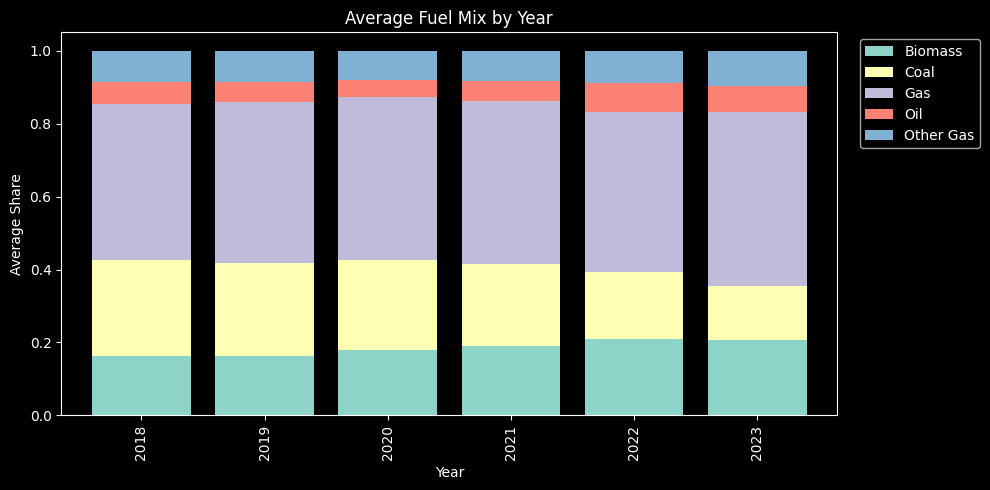


Sample Facility Time Series


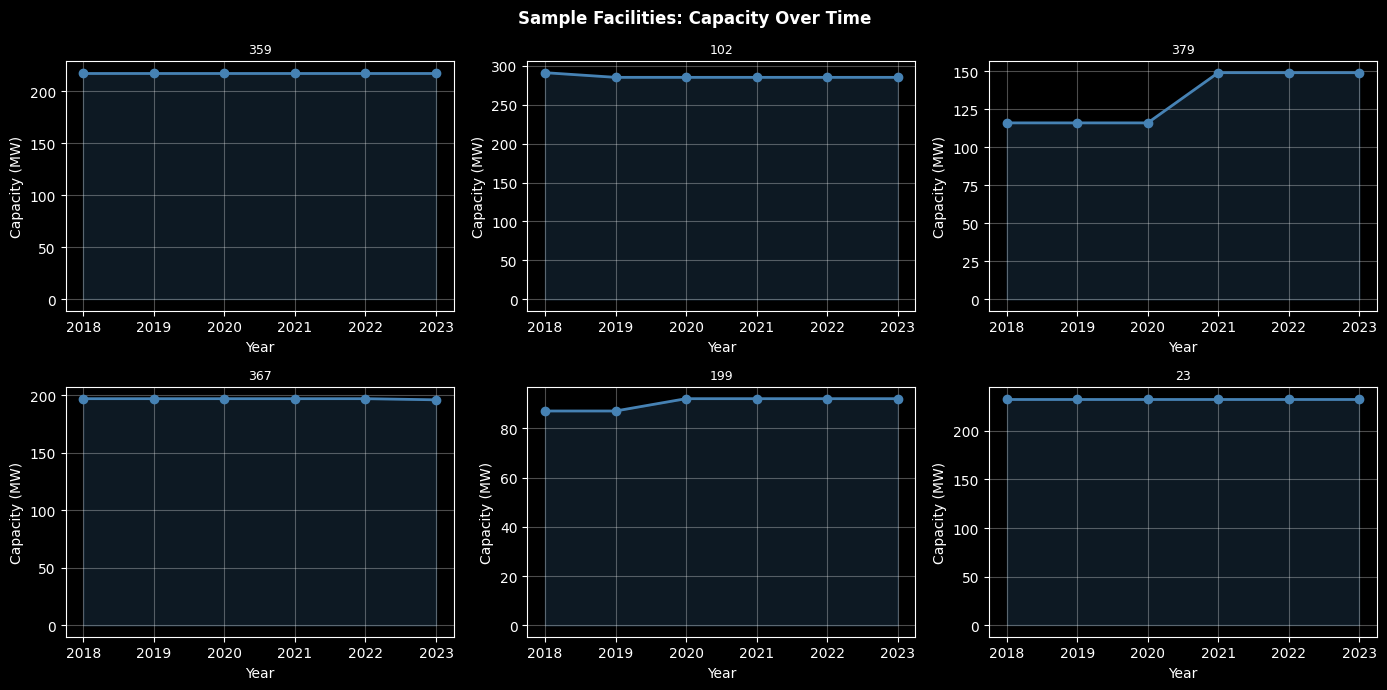

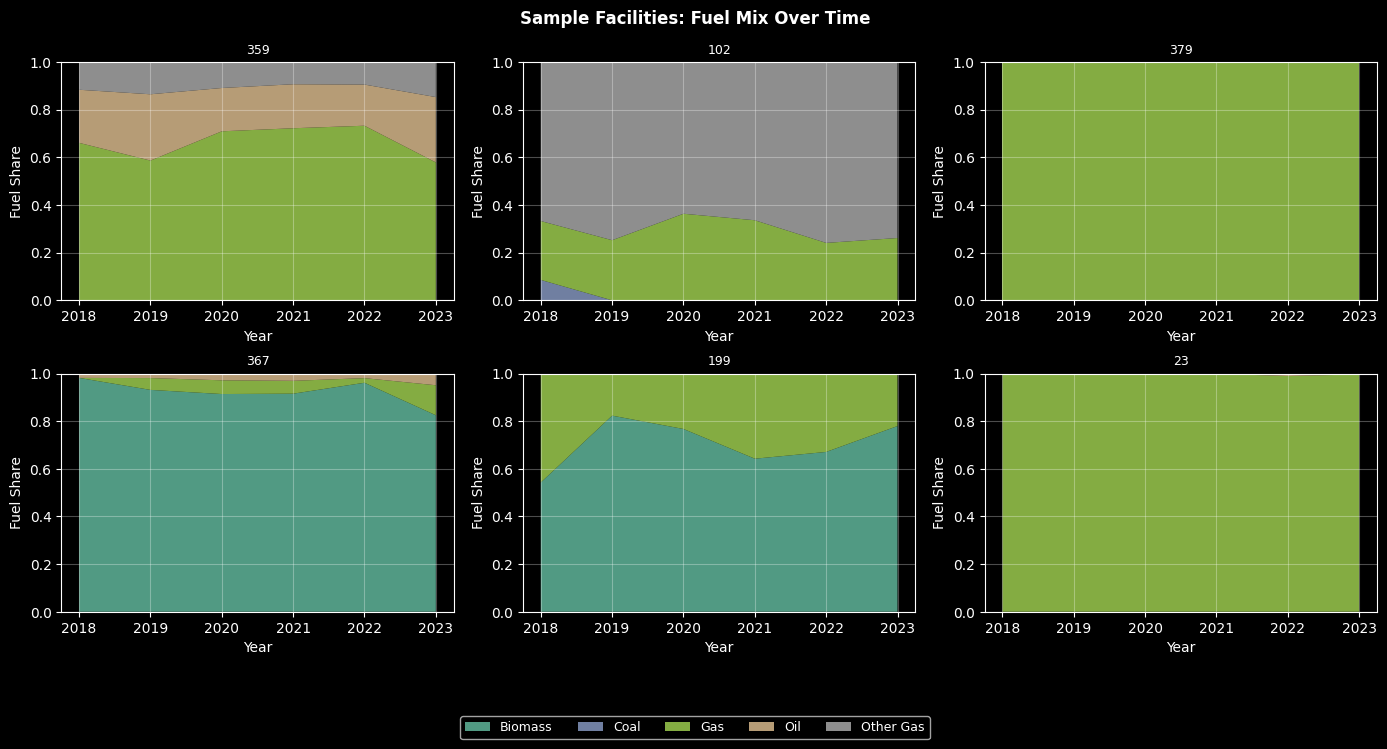

,country_code,n,share
4,FR,162,0.310940
10,PL,144,0.276392
12,SE,79,0.151631
0,AT,40,0.076775
3,ES,30,0.057582
8,LT,23,0.044146
1,EE,14,0.026871
5,HR,9,0.017274
2,EL,8,0.015355
11,PT,6,0.011516



Urbanization Analysis

Urbanization Degree (GHSL SMOD) Distribution:


,SMOD Code,Label,Count,Share
0,11,Very low density rural,20,3.8
1,12,Low density rural,78,15.0
2,13,Rural cluster,48,9.2
3,21,Suburban,120,23.0
4,22,Semi-dense urban,12,2.3
5,23,Dense urban,73,14.0
6,30,Urban centre,170,32.6


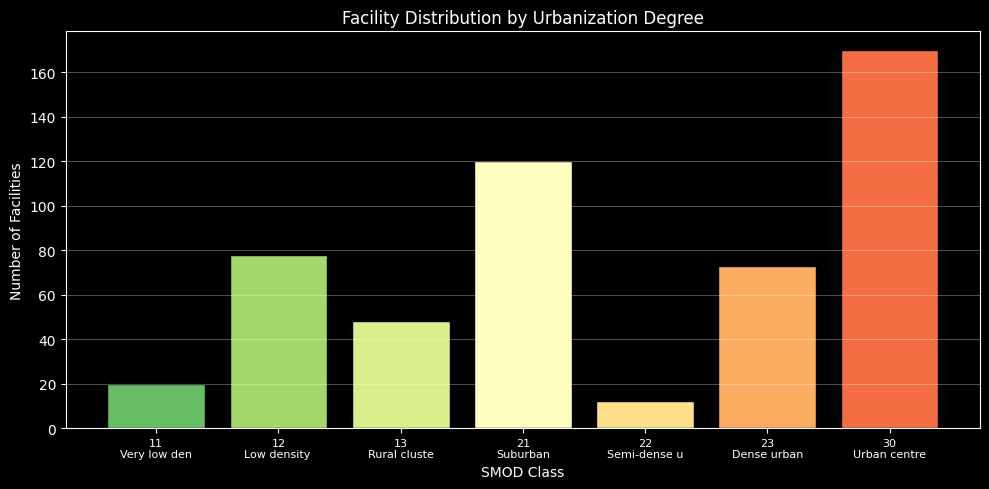


Urban/Rural Split (SMOD ≥21 = Urban):
  Urban: 375 (72.0%)
  Rural: 146 (28.0%)

NUTS2 Regional Distribution (All Facilities)


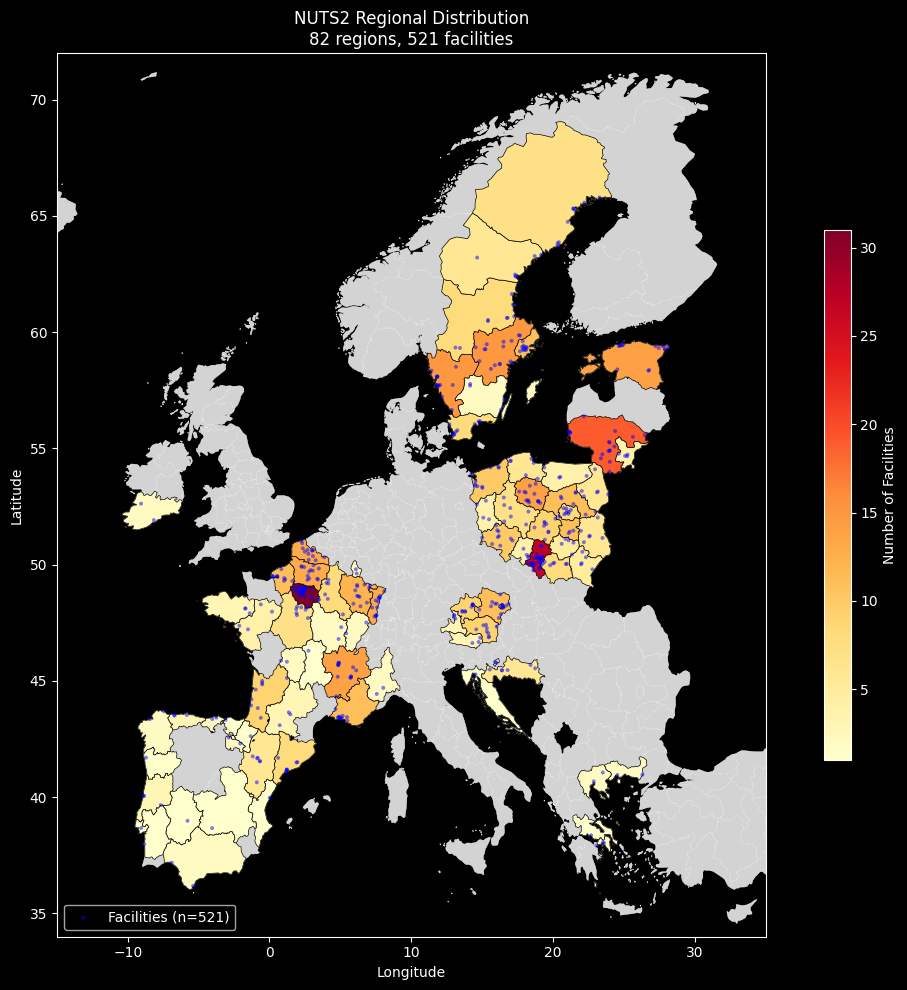


Top 10 NUTS2 Regions by Facility Count:


,NUTS_ID,n_facilities
0,FR10,31
1,PL22,27
2,LT02,19
3,SE12,15
4,SE23,15
5,PL61,14
6,FRK2,14
7,EE00,14
8,FRE2,13
9,FRF1,13



PyPSA Cluster Distribution (Electricity Facilities Only)
Electricity facilities: 421 / 521 (80.8%)
Matched 42 clusters with facilities (join column: 'name')


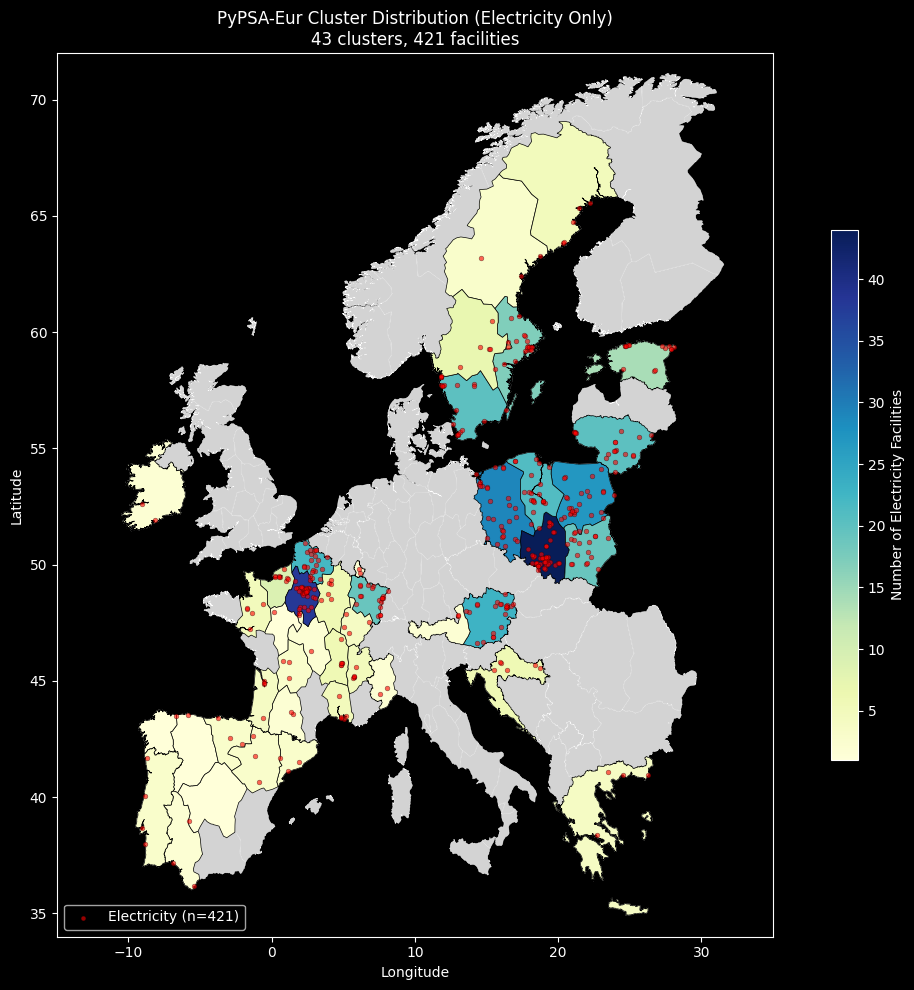


Top 10 PyPSA Clusters by Electricity Facility Count:


,name,n_facilities
0,PL0 2,44
1,FR0 9,38
2,PL0 1,29
3,PL0 0,27
4,AT0 0,23
5,FR0 2,22
6,PL0 3,21
7,SE1 2,20
8,LT0 0,20
9,PL0 4,19


In [31]:
from eda import fac_eda

facilities_static = pd.read_parquet("out/facilities_static.parquet")
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")
fac_eda(
    facilities_static, 
    facilities_yearly, 
    fac_id_col=FAC_ID_COL,
    nuts_geojson_path=NUTS_GEOJSON_PATH,
    pypsa_clusters_path=PYPSA_CLUSTERS_PATH,
    pypsa_resolution=PYPSA_RESOLUTION,
)

### 5.2 Time Varying ETS Stringency Data


1. Electricity Sector Analysis

Facility Classification (EU ETS Activity Codes):
  Electricity generators (codes 1, 20): 421 (80.8%)
  Other industrial:                     100 (19.2%)

Verified Emissions (tCO₂/yr) by Sector:
  Electricity: mean=0.25 MtCO₂, median=0.06 MtCO₂
  Other:       mean=0.67 MtCO₂, median=0.13 MtCO₂


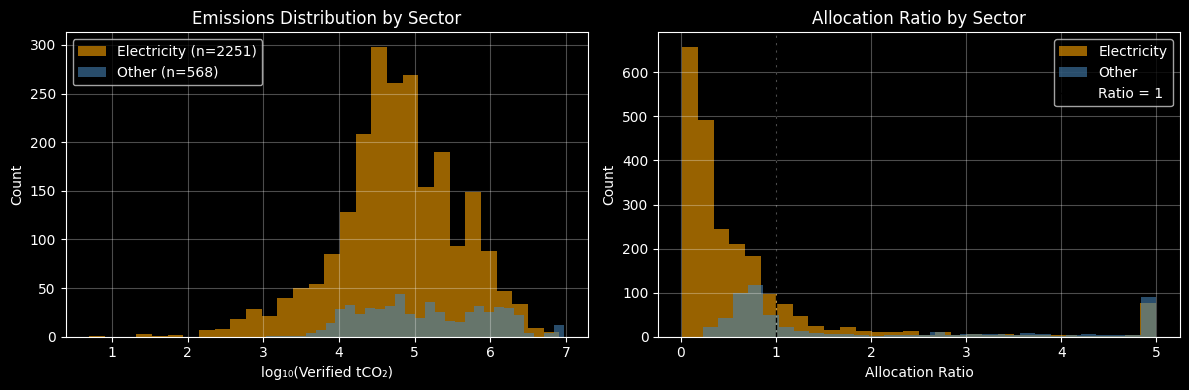


Aggregate Emissions by Year and Sector (MtCO₂):


is_electricity,Other,Electricity
year,,
2018,71.27,115.89
2019,72.14,104.18
2020,64.80,86.41
2021,69.90,91.91
2022,54.02,86.00
2023,49.52,72.39



2. Time Series for Sample Plants (allocatedTotal):


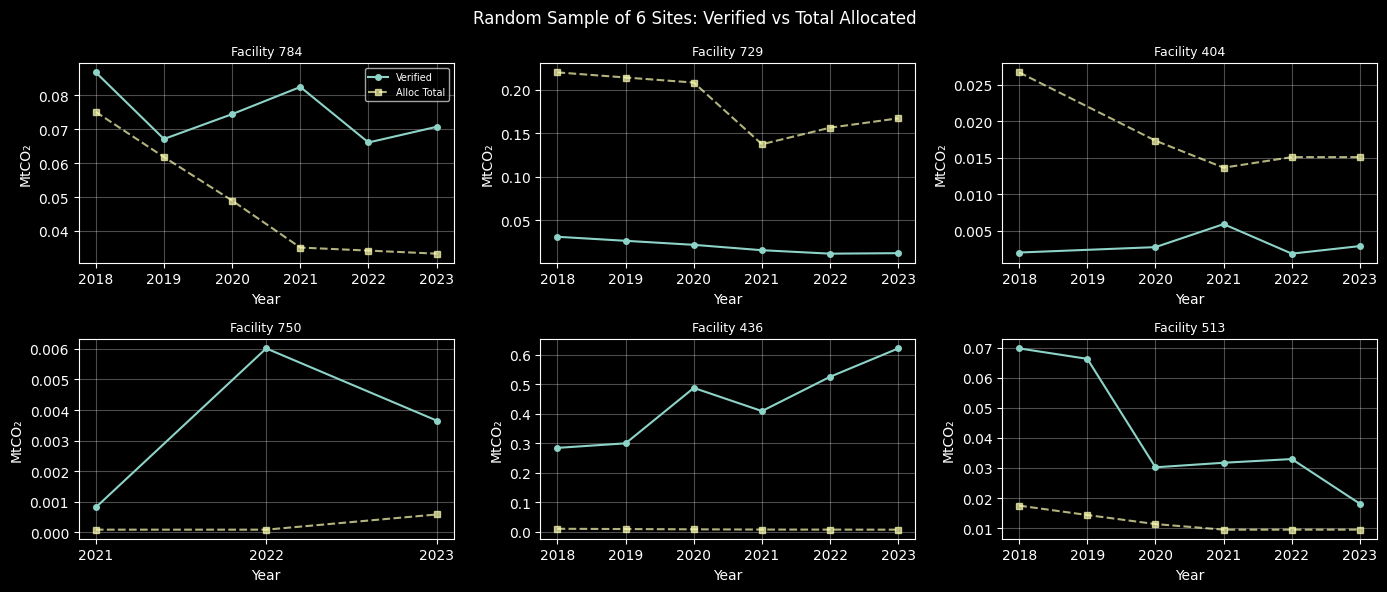

In [32]:
from eda import ets_eda

ets_eda(facilities_yearly, facilities_static=facilities_static, fac_id_col=FAC_ID_COL)

## 6. TROPOMI NO2 Emission Outcome

### Goal
Estimate yearly NOx emissions from each facility using the Beirle-style flux divergence (advection) method. This approach quantifies emissions by computing the spatial integral of the wind-driven advection of NO₂ concentrations, then applying a lifetime correction.

### Data
- **TROPOMI (Sentinel-5P) L3:** NO₂ daily overpasses. **Data available from 2018**. Dataset: [NO₂](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2).
- **Winds (ERA5-Land Hourly):** Daily mean u10/v10 for wind fields. Resolution ~11 km. Dataset: [ECMWF/ERA5_LAND/HOURLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY).

### Method: Beirle Flux Divergence (Advection)

Following **Beirle et al. (2023)**, ESSD 15, 3051–3073:

1. **For each day with valid TROPOMI data:**
   - Compute horizontal gradient ∇V of NOx TVCD (mol/m²) at each pixel
   - Compute advection: $A = \mathbf{w} \cdot \nabla V$ (scalar product of wind and gradient)
   - "The advection is calculated as the scalar product of the wind vector and the gradient of the TVCD... The resulting scalar A is independent from the coordinate system." (Sect. 3.5-3.6)

2. **Temporal averaging:**
   - Aggregate daily advection maps to yearly means (pixelwise)
   - Compute standard error of the mean for uncertainty quantification

3. **Spatial integration:**
   - Integrate mean advection within 15 km radius around facility
   - "We have simplified the calculation of emissions by just integrating the advection map spatially 15 km around the point source location." (Sect. 3.10.1)

4. **Lifetime correction:**
   - Apply correction factor $c_τ = \exp(t_r/τ)$ where $t_r = R/|w|$ is residence time
   - τ from Lange et al. (2022): $τ = 1.90 + 0.027 × |lat|$ hours
   - "The lifetime correction has to compensate for the integrated loss within the residence time" (Sect. 3.10.2)

5. **NO₂ → NOx scaling:**
   - Using photostationary state: NOx/NO₂ ≈ 1.38 ± 0.10 for mid-latitudes (Sect. 3.4)

### Key Parameters (from Beirle v2)
| Parameter | Value | Source |
|-----------|-------|--------|
| Integration radius | 15 km | Sect. 3.10.1 |
| Plume height | 500 m above ground | Sect. 3.12.3 |
| Min wind speed | 2 m/s | Sect. 3.5 |
| Detection limit (generic) | 0.11 kg/s | Sect. 3.11.1 |
| Detection limit (ideal) | 0.03 kg/s | Sect. 3.11.1 |

### Uncertainty Components
Following Beirle et al. (2023) Sect. 3.12:
- **Statistical error**: Standard error of temporal mean, propagated through spatial integration
- **Lifetime correction**: 50% relative uncertainty (Sect. 3.12.1)
- **OFFL vs PAL product**: ±25% (from 10-40% TVCD difference noted in Sect. 5.3.7)
- **NOx/NO₂ scaling**: ~10% (Sect. 3.4)

### References — Beirle NOx Outcome

**Core methodology:**
- Beirle et al. (2023) — *Improved catalog of NOx point source emissions (version 2)*. ESSD 15, 3051–3073. [doi:10.5194/essd-15-3051-2023](https://doi.org/10.5194/essd-15-3051-2023)
- Beirle et al. (2021) — *Pinpointing nitrogen oxide emissions from space*. ESSD 13, 2995–3012. [doi:10.5194/essd-13-2995-2021](https://doi.org/10.5194/essd-13-2995-2021)

**Lifetime parameterization:**
- Lange et al. (2022) — *NOx lifetime and emissions from cities and power plants worldwide*. (provides τ = 1.90 + 0.027 × |lat|)

**NO₂ photolysis / NOx scaling:**
- Dickerson et al. (1982) — J_NO2 parameterization by solar zenith angle
- IUPAC (2013) — Rate constant k for NO + O₃ reaction

**Technical documentation & data products:**
- Sentinel-5P OFFL L3 NO₂ – Google Earth Engine. [developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2)
- ERA5-Land Hourly – Google Earth Engine. [developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY)

### Load Data and Initialize Earth Engine

In [33]:
# =============================================================================
# Initialize Earth Engine and load facility data
# =============================================================================
import ee  # type: ignore

try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# Load facility data
facilities_static = pd.read_parquet("out/facilities_static.parquet")
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")

print(f"Loaded: {len(facilities_static):,} facilities, {len(facilities_yearly):,} facility-years")
print(f"Years in panel: {sorted(int(y) for y in facilities_yearly['year'].unique())}")
print("Earth Engine initialized.")

Loaded: 521 facilities, 2,819 facility-years
Years in panel: [2018, 2019, 2020, 2021, 2022, 2023]
Earth Engine initialized.


### Diagnostic: Visualize Advection Field for a Sample Facility

This visualizes the **raw advection field** $A = \mathbf{w} \cdot \nabla V$ (wind dotted with NO₂ gradient), which is the intermediate 2D field *before* spatial integration.

**What to expect for a point source:**
- **Red (positive A)**: Upwind of source—concentration increases in wind direction (wind blowing toward higher values at source)
- **Blue (negative A)**: Downwind of source—concentration decreases in wind direction (plume dispersing away from source)
- **Spatial pattern**: A dipole structure centered on the facility, with **red upwind** and **blue downwind**

In [34]:
# Sample a random facility for diagnostic visualization
# Uses annual mean (matching beirle_panel methodology)
# Retries if data unavailable for selected facility
# This cell can take a while to run.
# Rerun if you get a NoneType Error
from satellite_outcome import plot_advection_map

max_tries = 5
for attempt in range(max_tries):
    sample_fac = facilities_static.sample(1).iloc[0]
    print(f"Attempt {attempt+1}: {sample_fac['name']} (idx={sample_fac['idx']}, {sample_fac['country_code']})")
    print(f"  Coordinates: ({sample_fac['lat']:.4f}, {sample_fac['lon']:.4f})")
    
    try:
        m = plot_advection_map(lon=sample_fac['lon'], lat=sample_fac['lat'], year=2022)
        break  # Success
    except ValueError as e:
        print(f"  Error: {e}")
        if attempt == max_tries - 1:
            print("Max retries reached.")
            m = None

m # type: ignore

Attempt 1: ['"Kessel 6"'] (idx=2, AT)
  Coordinates: (48.3248, 16.0385)
Searching for a windy month in 2022...
  Selected: 2022-01 with 2.9 m/s
Using 2022-01: 2.9 m/s from W (285 deg)
Fetching advection map (this may take a minute)...
Advection range (2nd-98th pctl): [-2.06e-08, 1.79e-08]


Map(center=[np.float64(48.324806), np.float64(16.0385)], controls=(WidgetControl(options=['position', 'transpa…

### Build Facility × Year NOx Panel

Build the Beirle-style NOx emission panel using the `satellite_outcome` module. 

#### Batch Workflow
1. **Cell 1:** Submit batch export tasks to GEE (12 tasks per year, one per month)
2. **Wait:** Tasks run on GEE servers (monitor via [GEE Task Manager](https://code.earthengine.google.com/tasks))
3. **Download:** Download CSV files from Google Drive folder `ee_beirle_exports`
4. **Cell 2:** Load CSVs and aggregate to yearly panel

#### Output columns
- `beirle_nox_kg_s`: Estimated NOx emission rate (kg/s)
- `beirle_nox_kg_s_se`: Statistical standard error
- `rel_err_total`: Combined relative uncertainty (~35-45%)
- `n_days_satellite`: Number of valid satellite days

#### Step 1: Submit Batch Export Tasks to GEE

In [ ]:
# This cell submits batch tasks to Google Earth Engine servers.
# Tasks run asynchronously - you can close this notebook and check progress via:
#   https://code.earthengine.google.com/tasks
#
# After tasks complete, download CSVs from Google Drive folder 'ee_beirle_exports'
# Then run the next cell to aggregate results.

from satellite_outcome import export_beirle_year_batch

os.makedirs("out", exist_ok=True)

# Load facilities
facilities_static = pd.read_parquet("out/facilities_static.parquet")
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")

# Get years from the facilities panel
years = sorted(facilities_yearly['year'].unique())
print(f"Submitting batch tasks for years: {years}")
print(f"Facilities: {len(facilities_static)}")

# Submit batch tasks for each year (12 tasks per year, one per month)
all_tasks = []
for year in years:
    print(f"\n{'='*60}")
    print(f"Year {year}")
    print(f"{'='*60}")
    tasks = export_beirle_year_batch(
        facilities_static=facilities_static,
        year=int(year),
        fac_id_col=FAC_ID_COL,
        drive_folder='ee_beirle_exports',
        start_immediately=True,
    )
    all_tasks.extend(tasks)

print(f"\n{'='*60}")
print(f"SUBMITTED {len(all_tasks)} BATCH TASKS")
print(f"{'='*60}")
print(f"Monitor progress at: https://code.earthengine.google.com/tasks")
print(f"After completion, download CSVs from Google Drive folder 'ee_beirle_exports' and place in 'data/ee_beirle_exports'")
print(f"Then run the next cell to aggregate results.")

Submitting batch tasks for years: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Facilities: 521

Year 2018
Started task: beirle_2018_01
Started task: beirle_2018_02
Started task: beirle_2018_03
Started task: beirle_2018_04
Started task: beirle_2018_05
Started task: beirle_2018_06
Started task: beirle_2018_07
Started task: beirle_2018_08
Started task: beirle_2018_09
Started task: beirle_2018_10
Started task: beirle_2018_11
Started task: beirle_2018_12

Year 2019
Started task: beirle_2019_01
Started task: beirle_2019_02
Started task: beirle_2019_03
Started task: beirle_2019_04
Started task: beirle_2019_05
Started task: beirle_2019_06
Started task: beirle_2019_07
Started task: beirle_2019_08
Started task: beirle_2019_09
Started task: beirle_2019_10
Started task: beirle_2019_11
Started task: beirle_2019_12

Year 2020
Started task: beirle_2020_01
Started task: beirle_2020_02
Started task: beirle_2020_03
Started task: beirle_2020_04
Started 

#### Step 2: Load Results, Calculate Outcome and Aggregate to Yearly Panel

In [2]:
# Run this cell after:
#   1. Batch tasks have completed (check https://code.earthengine.google.com/tasks)
#   2. CSVs downloaded from Google Drive folder 'ee_beirle_exports' to ~/Downloads
#
# This cell:
#   - Loads daily facility-level CSV exports
#   - Applies wind speed filter (>= 2 m/s)
#   - Computes lifetime correction per day
#   - Aggregates to yearly emissions with uncertainty propagation

from satellite_outcome import (
    load_batch_results, 
    aggregate_batch_to_yearly
)

# Load and aggregate results for each year
facilities_static = pd.read_parquet("out/facilities_static.parquet")
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")
years = sorted(facilities_yearly['year'].unique())

all_yearly = []
for year in years:
    print(f"\n{'='*60}")
    print(f"Processing {year}")
    print(f"{'='*60}")
    
    try:
        # Load daily results from downloaded CSVs
        daily = load_batch_results(
            year=int(year),
            drive_download_dir=BEIRLE_EXPORT_DIR,
            file_prefix='beirle',
        )
        print(f"  Loaded {len(daily):,} daily facility observations")
        
        # Aggregate to yearly
        yearly = aggregate_batch_to_yearly(
            daily_df=daily,
            fac_id_col=FAC_ID_COL,
            min_valid_days=MIN_DAYS_PER_YEAR,
        )
        print(f"  Aggregated to {len(yearly):,} facility-years")
        all_yearly.append(yearly)
        
    except FileNotFoundError as e:
        print(f"  ERROR: {e}")
        print(f"  Download CSVs from Google Drive and try again.")

# Combine all years and save
if all_yearly:
    beirle_panel = pd.concat(all_yearly, ignore_index=True)
    
    # Save
    beirle_panel.to_parquet("out/beirle_panel.parquet", index=False)
    print(f"\n{'='*60}")
    print(f"SAVED: out/beirle_panel.parquet")
    print(f"  {len(beirle_panel):,} facility-years")
    print(f"  Columns: {list(beirle_panel.columns)}")
    print(f"{'='*60}")
else:
    print("\nNo data loaded. Check that CSVs are downloaded from Google Drive.")


Processing 2018
Loading 11 files for 2018...
  Loaded 174,014 rows for 2018
  Loaded 174,014 daily facility observations
Dropped 288 observations with rel_err_total > 50% (60.0% of sample)
  Aggregated to 192 facility-years

Processing 2019
Loading 12 files for 2019...
  Loaded 190,165 rows for 2019
  Loaded 190,165 daily facility observations
Dropped 278 observations with rel_err_total > 50% (56.0% of sample)
  Aggregated to 218 facility-years

Processing 2020
Loading 12 files for 2020...
  Loaded 190,686 rows for 2020
  Loaded 190,686 daily facility observations
Dropped 317 observations with rel_err_total > 50% (63.3% of sample)
  Aggregated to 184 facility-years

Processing 2021
Loading 12 files for 2021...
  Loaded 190,165 rows for 2021
  Loaded 190,165 daily facility observations
Dropped 278 observations with rel_err_total > 50% (55.9% of sample)
  Aggregated to 219 facility-years

Processing 2022
Loading 12 files for 2022...
  Loaded 190,165 rows for 2022
  Loaded 190,165 daily 

## 6. NOx Emission Outcome - EDA

Exploratory analysis of the Beirle-style NOx emission estimates.

BEIRLE NOx EMISSION EDA
Facility-years: 1,213 | Facilities: 291
Years: 2018–2023

----------------------------------------
1. Summary Statistics
----------------------------------------


,count,mean,std,min,25%,50%,75%,max,non_null
beirle_nox_kg_s,1213.0,0.0647,0.0690,-0.1541,0.0283,0.0454,0.0796,0.3690,1213
c_tau_mean,1213.0,1.3832,0.0736,1.2522,1.3458,1.3750,1.4070,1.8794,1213
rel_err_total,1213.0,0.4033,0.0431,0.3357,0.3680,0.3924,0.4352,0.5000,1213
n_days_satellite,1213.0,138.8261,45.4595,27.0000,116.0000,144.0000,163.0000,328.0000,1213



----------------------------------------
2. Distribution of NOx Emissions
----------------------------------------


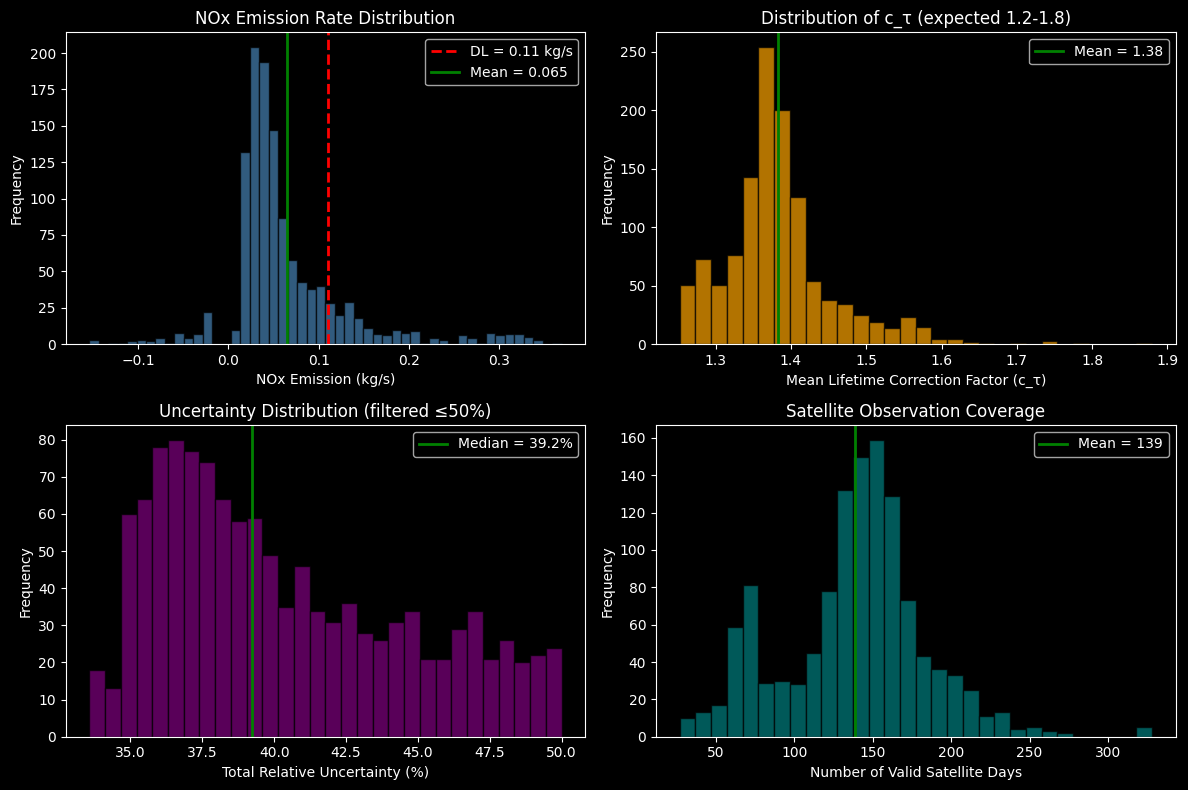


----------------------------------------
3. Detection Limit Analysis
----------------------------------------
Above generic DL (0.11 kg/s): 196 (16.2%)
Above ideal DL (0.03 kg/s): 887 (73.1%)

----------------------------------------
4. Emissions by Country
----------------------------------------


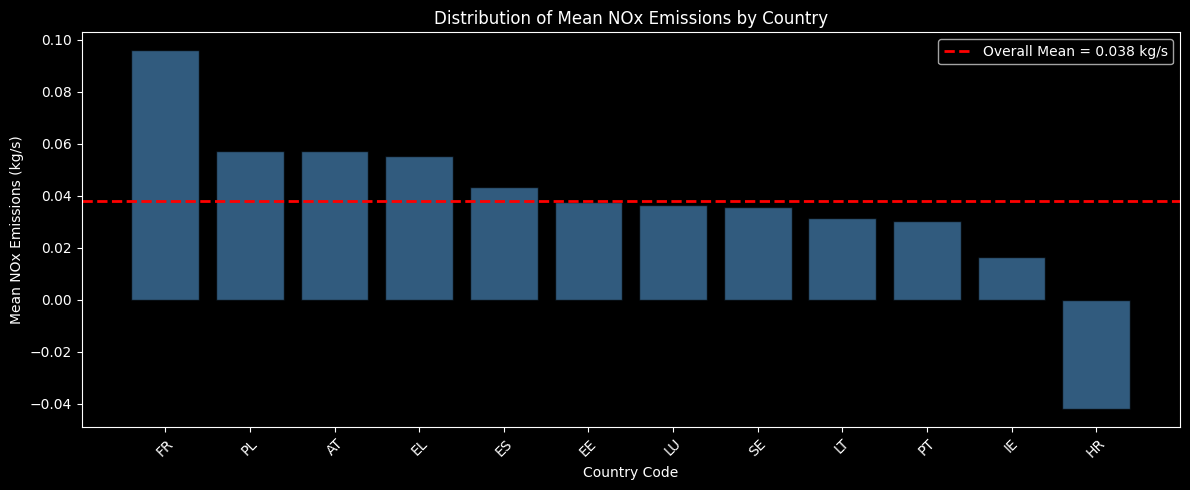

In [35]:
from eda import beirle_eda

# Load and run EDA
facilities_static = pd.read_parquet("out/facilities_static.parquet")
beirle_panel = pd.read_parquet("out/beirle_panel.parquet")
beirle_eda(beirle_panel, facilities_static)

## 7. AlphaEarth Geographic Embeddings

Download **Google AlphaEarth Satellite Embeddings** for each facility to capture geographic context as high-dimensional features.

### Module: `embeddings.py`
Embedding functions are implemented in `src/data/embeddings.py`:
- `test_embedding_sample()` - Quick connectivity/coverage test
- `sample_embeddings_for_year()` - Core per-year sampling logic
- `build_embedding_panel()` - Full panel builder with yearly caching

### AlphaEarth Overview
- **Source**: `GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL` (Earth Engine)
- **Paper**: [arXiv:2507.22291](https://arxiv.org/abs/2507.22291)
- **Native resolution**: 4m per pixel
- **Dimensions**: 64 embedding dimensions (bands A00–A63)

### Sampling Strategy
- **10km scale**: Each facility gets the mean embedding of its 10km × 10km grid cell
- **Yearly composites**: Temporal variation captured across years
- Matches the 0–10km inner portion of the pollution near ring

### Use Case
The embeddings capture high-dimensional learned features from satellite imagery that correlate with:
- Land use patterns (urban density, industrial clustering)
- Vegetation and terrain
- Infrastructure and built environment
- Climate and weather patterns

These 64-dimensional embeddings provide a compact representation of the geographic context around each facility, useful for controlling for spatial heterogeneity between plants.

#### Step 1: Submit Batch Export Tasks to GEE

In [ ]:
from embeddings import export_embeddings_multi_year

# Load facilities
facilities_static = pd.read_parquet("out/facilities_static.parquet")

# Submit batch export tasks to GEE (one per year)
years = list(range(START_YEAR, END_YEAR + 1))
emb_tasks = export_embeddings_multi_year(
    facilities_static=facilities_static,
    years=years,
    fac_id_col=FAC_ID_COL,
)

print("\nMonitor tasks at: https://code.earthengine.google.com/tasks")
print("Once complete, download CSVs from Google Drive folder: ee_embedding_exports/")

Testing facility 0 at (48.07, 14.81)
✓ Test passed: A00=-0.1600, A01=-0.1477
Started task: emb_2018
Started task: emb_2019
Started task: emb_2020
Started task: emb_2021
Started task: emb_2022
Started task: emb_2023

Submitted 6 embedding export tasks for years 2018-2023

Monitor tasks at: https://code.earthengine.google.com/tasks
Once complete, download CSVs from Google Drive folder: ee_embedding_exports/


#### Step 2: Merge into Beirle Panel and Save

In [4]:
from embeddings import load_embedding_results
# Load exported CSVs from Google Drive downloads
years = list(range(START_YEAR, END_YEAR + 1))
emb_panel = load_embedding_results(
    years=years,
    drive_download_dir=EMBEDDING_EXPORT_DIR,
    file_prefix='emb',
    fac_id_col=FAC_ID_COL,
)

# Merge with beirle panel and save final output
beirle_panel = pd.read_parquet("out/beirle_panel.parquet")
final_panel = beirle_panel.merge(
    emb_panel.drop(columns=['lat', 'lon'], errors='ignore'),
    on=[FAC_ID_COL, 'year'],
    how='left'
)

final_panel.to_parquet("out/beirle_panel.parquet", index=False)
print(f"\nSaved final panel: {len(final_panel):,} rows with embeddings")

  Loaded 521 rows for 2018
  Loaded 521 rows for 2020
  Loaded 521 rows for 2021
  Loaded 521 rows for 2022
  Loaded 521 rows for 2023

Combined embedding panel: 2,605 rows, 521 facilities, 64 dimensions
  Valid embeddings: 2,605 (100.0%)

Saved final panel: 1,213 rows with embeddings


In [36]:
emb_panel.head()

,idx,year,lat,lon,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,...,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63
0,0,2018,48.070278,14.808389,-0.135886,-0.141730,-0.103406,-0.113741,0.160000,-0.062991,...,0.327812,0.012057,-0.088827,-0.079723,-0.124567,-0.044844,0.041584,-0.199862,0.000062,-0.032541
1,1,2018,47.975500,13.616778,-0.103406,-0.206936,-0.084214,-0.084214,0.179377,-0.119093,...,0.327812,0.093564,-0.103406,-0.035433,-0.166336,0.003014,0.059116,-0.098424,0.000554,-0.015748
2,2,2018,48.324806,16.038500,-0.166336,-0.130165,-0.051734,-0.160000,0.130165,-0.079723,...,0.284444,-0.017778,-0.035433,-0.141730,-0.098424,-0.055363,0.006151,-0.192910,-0.008858,-0.013841
3,3,2018,48.236889,16.702389,-0.135886,-0.124567,-0.098424,-0.172795,0.147697,-0.004983,...,0.251965,-0.051734,-0.093564,-0.179377,-0.093564,-0.048228,-0.017778,-0.186082,0.019931,0.038447
4,4,2018,48.316222,16.875083,-0.124567,-0.141730,-0.130165,-0.166336,0.166336,0.006151,...,0.221453,-0.027128,-0.079723,-0.160000,-0.075356,-0.038447,0.007443,-0.172795,0.019931,0.015748
